In [1]:
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd
import requests

%matplotlib inline
import seaborn as sns; sns.set()
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
#Enlargen
sns.set_context('poster')

In [2]:
# Scrape Electoral Votes Series

r = requests.get('https://en.wikipedia.org/wiki/Electoral_College_(United_States)')
soup = BeautifulSoup(r.text, "lxml")

electoral_vote_table = soup.findAll('table','wikitable')[0] # Hard-coding that it's the first table

rows = electoral_vote_table.findAll('tr')

state_rows = [row.findAll('td')[1].getText().replace('*','')
                                            .replace('(−2)','')
                                            .replace('(+1)','')
                                            .replace('(+4)','')
                                            .replace('(+2)','')
                                            .replace('(−1)','') for row in rows[1:]]

state_rows = state_rows[:-1] # Drop last row with total electors

votes = [row.findAll('td')[0].getText().split()[0] for row in rows[1:-1]] 
# Votes are in first number in first column of all rows except first and last

electoral_vote_series = pd.Series(name='Electoral Votes')
for index, row in enumerate(state_rows):
    states = row.split(',')
    for state in states:
        electoral_vote_series[state.strip()] = votes[index]

In [3]:
# Scrape State Population Series

r = requests.get('https://en.wikipedia.org/wiki/List_of_U.S._states_and_territories_by_population')
soup = BeautifulSoup(r.text, "lxml")

population_table = soup.findAll('table','wikitable')[0] # Hard-coding that it's the first table

rows = population_table.findAll('tr')
population_cells = [row.findAll('td')[3].contents for row in rows[1:53]] # Drop header row; population in fourth column
populations = [item for sublist in population_cells for item in sublist] # Un-nest

state_cells = [row.findAll('td')[2].contents for row in rows[1:53]] # Drop header row; population in third column
states = [cell[1].contents for cell in state_cells] # Need to skip flag information in state_cells
states = [item for sublist in states for item in sublist] # Un-nest

population_series = pd.Series(populations, index=states, name='July 2015 Population')

In [4]:
# Merge into one DF

df = pd.DataFrame([electoral_vote_series,population_series]).transpose()
df.drop('Puerto Rico', inplace=True) # You have great waves but no electoral votes
df['July 2015 Population'] = [int(x.replace(',','')) for x in df['July 2015 Population']]
df['Electoral Votes'] = [int(x) for x in df['Electoral Votes']]

equal_fractional_vote = df.sum()['Electoral Votes']/df.sum()['July 2015 Population']
df['Electoral Votes Per Capita'] = df['Electoral Votes']/df['July 2015 Population']
df['Percent Diff From Fair'] = (100*(df['Electoral Votes Per Capita'] - equal_fractional_vote))/equal_fractional_vote

largest_fractional_vote = df.sort_values('Percent Diff From Fair').ix[-1,'Electoral Votes Per Capita']
df['Percent Diff From Wyoming'] = (100*(df['Electoral Votes Per Capita'] - largest_fractional_vote))/largest_fractional_vote
df['Fraction of a Wyomingite'] = 100 + df['Percent Diff From Wyoming']

In [15]:
df_for_mapping = df[['Electoral Votes Per Capita','Percent Diff From Fair', 'Percent Diff From Wyoming']].copy()

In [16]:
df_for_mapping.reset_index(inplace=True)
df_for_mapping.columns = ['state', 'votespercap','difffair','diffwyoming']

In [18]:
df_for_mapping.to_csv('map_data.csv')

In [24]:
pd.DataFrame(df.sum())

,0
Electoral Votes,5.380000e+02
July 2015 Population,3.214188e+08
Electoral Votes Per Capita,1.143774e-04
Percent Diff From Fair,1.733280e+03
Percent Diff From Wyoming,-2.865420e+03
Fraction of a Wyomingite,2.234580e+03


In [26]:
df

,Electoral Votes,July 2015 Population,Electoral Votes Per Capita,Percent Diff From Fair,Percent Diff From Wyoming,Fraction of a Wyomingite
Alabama,9,4858979,0.000002,10.658942,-63.812953,36.187047
Alaska,3,738432,0.000004,142.716764,-20.628169,79.371831
Arizona,11,6828065,0.000002,-3.753695,-68.526090,31.473910
Arkansas,6,2978204,0.000002,20.361013,-60.640238,39.359762
California,55,39144818,0.000001,-16.058362,-72.549892,27.450108
Colorado,9,5456574,0.000002,-1.460243,-67.776099,32.223901
Connecticut,7,3590886,0.000002,16.462323,-61.915165,38.084835
Delaware,3,945934,0.000003,89.473922,-38.039335,61.960665
District of Columbia,3,672228,0.000004,166.620589,-12.811278,87.188722
Florida,29,20271272,0.000001,-14.531512,-72.050590,27.949410


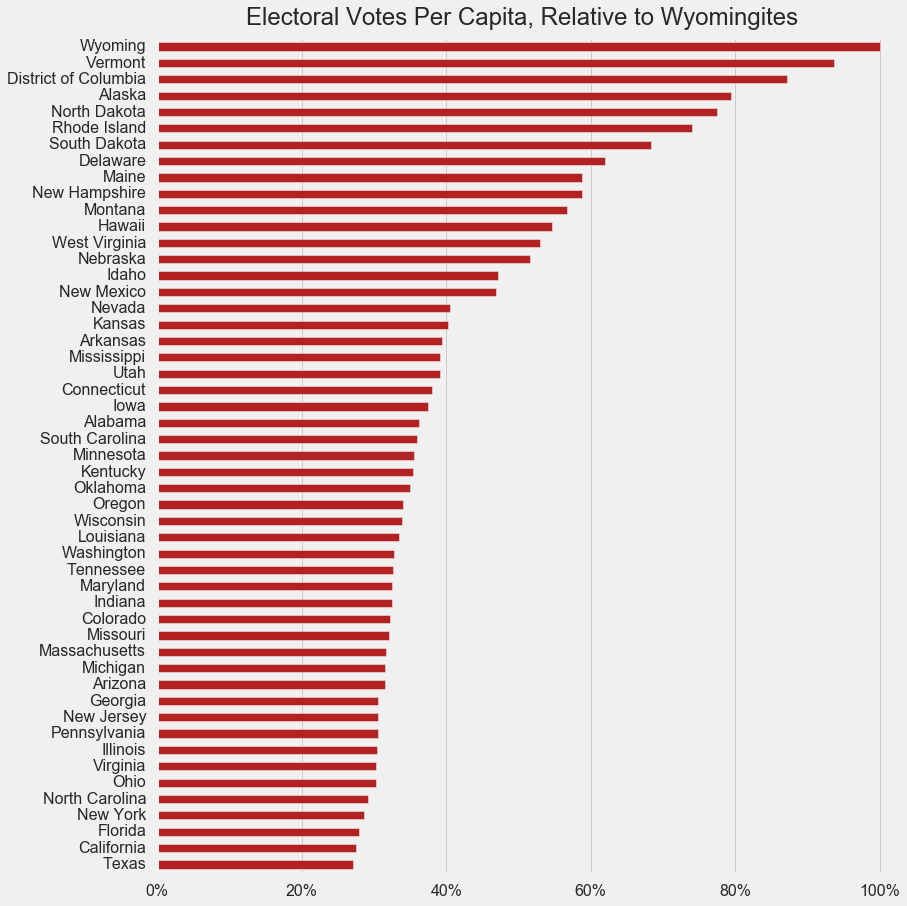

In [37]:
pylab.rcParams['figure.figsize'] = [12.8, 8.8] # Old Vals for reference

pylab.rcParams['figure.figsize'] = [12.8, 12.8]

with plt.style.context('fivethirtyeight'):
    df['Fraction of a Wyomingite'].sort_values(ascending=True).plot(kind='barh', color='FireBrick', xlim=(0,101))
    plt.title('Electoral Votes Per Capita, Relative to Wyomingites', y=1.01,fontsize=24)
    plt.gca().xaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%.0f%%'))
    plt.gca().yaxis.grid(False)
    plt.tight_layout()
    plt.savefig('./charts/vote_per_capita_relative_to_wyoming.png', dpi=200)


In [33]:
df['Fraction of a Wyomingite'].sort_values()

Texas                    27.026798
California               27.450108
Florida                  27.949410
New York                 28.620736
North Carolina           29.180452
Ohio                     30.280840
Virginia                 30.297019
Illinois                 30.383993
Pennsylvania             30.520438
New Jersey               30.533177
Georgia                  30.601535
Arizona                  31.473910
Michigan                 31.502948
Massachusetts            31.629755
Missouri                 32.113664
Colorado                 32.223901
Indiana                  32.464696
Maryland                 32.526799
Tennessee                32.560025
Washington               32.696140
Louisiana                33.462735
Wisconsin                33.851601
Oregon                   33.943679
Oklahoma                 34.964582
Kentucky                 35.320215
Minnesota                35.588971
South Carolina           35.912348
Alabama                  36.187047
Iowa                

In [6]:
#Write out a very greedy "make it fair" algorithm
#Take one electoral vote from 
# One version where you relax the 3 votes limitation